In [39]:
!pip install tensorflow_probability

In [40]:
import os
import sys
import matplotlib.pyplot as plt

if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')
import train_instrumentation as tinstr
import train_explainer as texpl

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from preprocessing import trainTestClean
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [41]:
df_train, df_test = trainTestClean()

X_train = df_train.drop(columns=['price', 'id'])
y_train = df_train['price'].values.reshape(-1, 1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))

X_test = df_test.drop(columns=['price', 'id'])
y_test = df_test['price'].values.reshape(-1, 1)

X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
 

In [42]:
variables = tinstr.VariableHistoryCallback(per_step=True)
gradients = tinstr.GradientHistoryCallback(per_step=True)
outputs = tinstr.LayerOutputHistoryCallback(per_step=True)
output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=True)

In [43]:
# not as interesting as I though (leakyReLu)
'''model = Sequential([
    
    keras.Input((93,)),

    layers.Dense(512),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),

    layers.Dense(256),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
    ])'''

'model = Sequential([\n    \n    keras.Input((93,)),\n\n    layers.Dense(512),\n    layers.LeakyReLU(negative_slope=0.1),\n    layers.BatchNormalization(), \n    layers.Dropout(0.2),\n\n    layers.Dense(256),\n    layers.LeakyReLU(negative_slope=0.1),\n    layers.BatchNormalization(),\n    layers.Dropout(0.2),\n\n    layers.Dense(1)\n    ])'

In [44]:
model = Sequential([
    keras.Input((94,)),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
    ])

In [45]:
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

In [46]:
batched_train = dataset.batch(32)
batched_test = test_dataset.batch(32)

history = tinstr.fit(model, batched_train, epochs=10, validation_data=batched_test, callbacks=[
    variables, gradients, outputs, output_gradients, tinstr.HistoryStats(per_step=True)])

Epoch 1/10
   1/1303 ━━━━━━━━━━━━━━━━━━━━ 32:24 1s/step - loss: 2.7890 - mae: 1.2913 - mse: 2.7890WARNING:tensorflow:5 out of the last 46913 calls to <function NormAccumulatorStrategy.norms at 0x3e8ce4680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 111s 84ms/step - loss: 2.8923 - mae: 0.7664 - mse: 2.8923 - val_loss: 0.5217 - val_mae: 0.4457 - val_mse: 0.5217
Epoch 2/10
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 99s 76ms/step - loss: 0.3091 - mae: 0.381

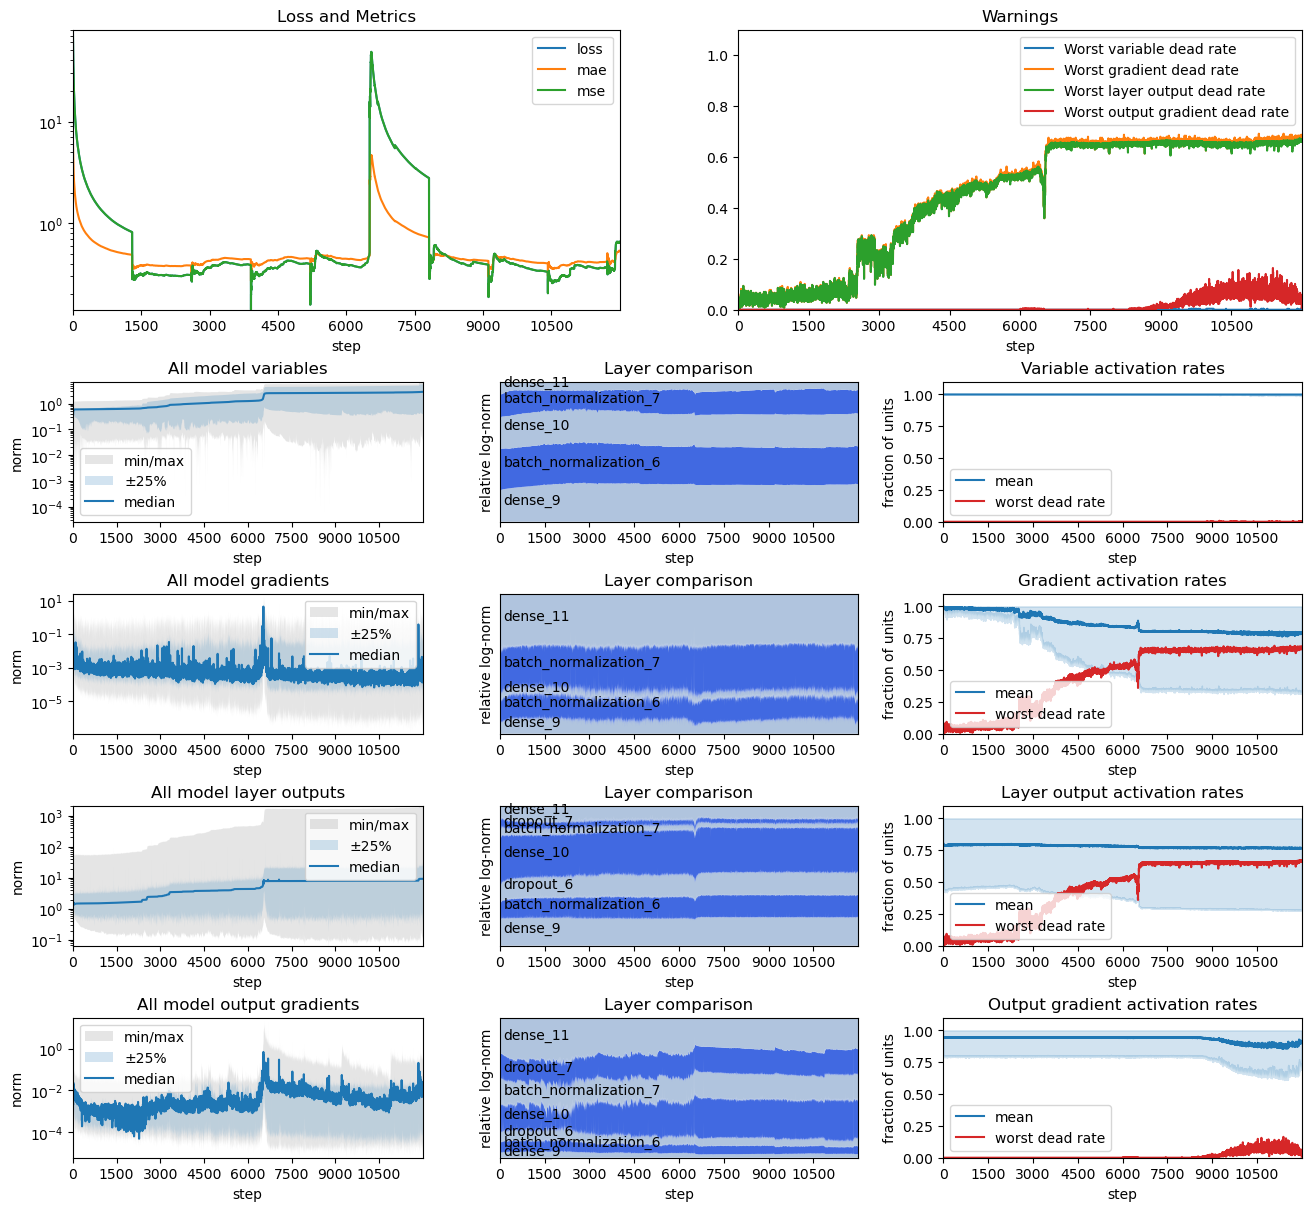

In [47]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients], iterations=slice(0, 12000))

In [48]:
preds = model.predict(X_test_scaled)
preds_real = y_scaler.inverse_transform(preds)

326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


In [49]:
preds_real

array([[217753.39],
       [188228.34],
       [158503.06],
       ...,
       [315920.25],
       [103052.  ],
       [257049.34]], dtype=float32)

In [50]:
# MAE
mae = mean_absolute_error(y_test, preds_real)

# MAPE
mape = mean_absolute_percentage_error(y_test, preds_real)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")

MAE: 85330.38
MAPE: 23.03%


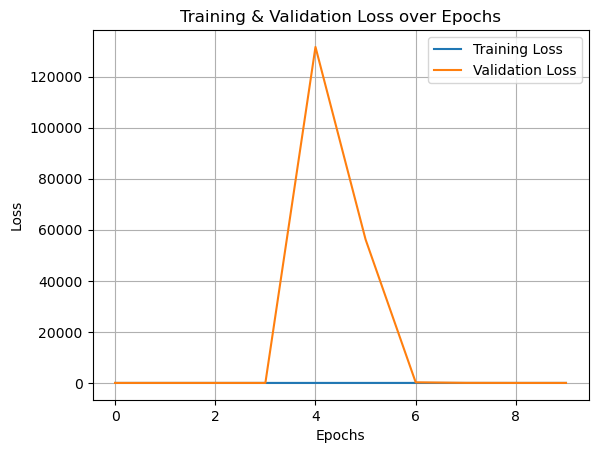

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

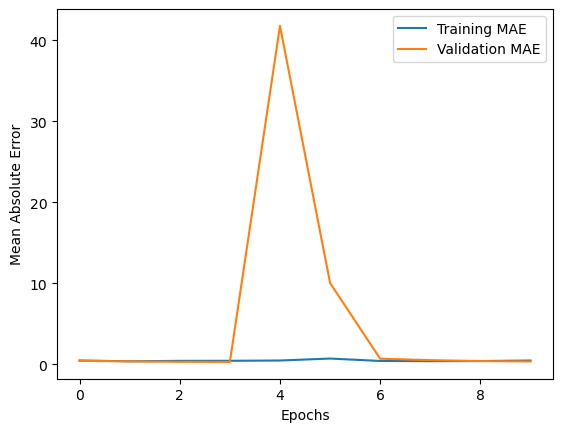

In [52]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [53]:
X_test_scaled = scaler.transform(X_test.drop(columns=['id']))
test_loss = model.evaluate(X_test_scaled, y_test)

NameError: name 'scaler' is not defined